In [1]:
import diffusers
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from src.dataset.dance_image import HumanDanceDataset
from src.dwpose import DWposeDetector
from src.models.mutual_self_attention import ReferenceAttentionControl
from src.models.pose_guider import PoseGuider
from src.models.unet_2d_condition import UNet2DConditionModel
from src.models.unet_3d import UNet3DConditionModel
from src.pipelines.pipeline_pose2img import Pose2ImagePipeline
from src.utils.util import delete_additional_ckpt, import_filename, seed_everything
import torch
import matplotlib.pyplot as plt

import sys

sys.path.append('/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Open-AnimateAnyone')
from models.PoseGuider import PoseGuider as pg

/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/root/miniconda3/envs/animateAnyone/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/root/miniconda3/envs/ani

[2024-01-19 16:08:56,717] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# poseguider = pg(noise_latent_channels=4).to('cuda')
# poseguider.requires_grad_(True)

In [3]:
pose_guider = PoseGuider(
            conditioning_embedding_channels=320, block_out_channels=(16, 32, 96, 256)
        ).to(device="cuda")

In [4]:
controlnet_openpose_state_dict = torch.load('/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/pretrained_weights/pose_guider.pth')

In [5]:
state_dict_to_load = {}
for k in controlnet_openpose_state_dict.keys():
    if k.startswith("controlnet_cond_embedding.") and k.find("conv_out") < 0:
        new_k = k.replace("controlnet_cond_embedding.", "")
        state_dict_to_load[new_k] = controlnet_openpose_state_dict[k]
miss, _ = pose_guider.load_state_dict(state_dict_to_load, strict=False)

In [6]:
pose_guider.requires_grad_(True)

PoseGuider(
  (conv_in): InflatedConv3d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (blocks): ModuleList(
    (0): InflatedConv3d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InflatedConv3d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): InflatedConv3d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): InflatedConv3d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InflatedConv3d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): InflatedConv3d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (conv_out): InflatedConv3d(256, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [7]:
train_dataset = HumanDanceDataset(
        img_size=(512, 512),
        img_scale=(0.9, 1.0),
        img_ratio=(0.9, 1.0),
        data_meta_paths=["/cephfs/SZ-AI/usr/liuchenyu/HaiLook/Moore-AnimateAnyone/data/UBC_fashion_meta.json"],
        sample_margin=30,
    )

In [8]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=1
    )

In [9]:
img=None
tgt_pose_img=None
ref=None
clip = None

for step, batch in enumerate(train_dataloader):
    img = batch["img"]
    tgt_pose_img = batch["tgt_pose"]
    ref = batch["ref_img"]
    clip=batch["clip_images"]
    
    if step==0:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


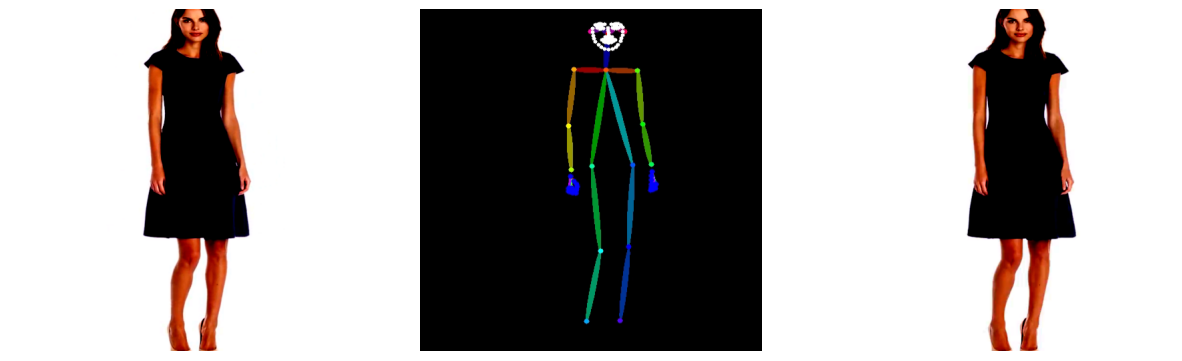

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(ref[0].permute(1,2,0))
axs[1].imshow(tgt_pose_img[0].permute(1,2,0))
axs[2].imshow(img[0].permute(1,2,0))
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()

In [11]:
tgt_pose_img_unsqueeze = tgt_pose_img.unsqueeze(2)

In [12]:
tgt_pose_img_unsqueeze = tgt_pose_img_unsqueeze.to(device="cuda")

In [13]:
tgt_pose_img_unsqueeze.dtype

torch.float32

In [14]:
pose_guider.dtype

torch.float32

In [15]:
pose_fea = pose_guider(tgt_pose_img_unsqueeze)

In [16]:
pose_fea.dtype

torch.float32

In [17]:
pose_fea

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
     

In [18]:
torch.nonzero(pose_fea)

tensor([], device='cuda:0', size=(0, 5), dtype=torch.int64)